# MC030 - Projeto final de Graduação
## Análise e Previsão do Mercado de Ações

## Descrição do modelo

A partir de um conjunto de cotações diárias de dólar para real (USD-BRL) desejamos modelar esse comportamento a partir de uma série de indicadores de mercado financeiro para classificarmos cada dia como um momento de compra ou momento de venda.

# ...

# Código

### Definindo endpoints da API (https://www.alphavantage.co/documentation/)

In [1]:
apiToken = '3GX5M109KQK9B6HO'
baseUrl = 'https://www.alphavantage.co/query?&outputsize=full&apikey=' + apiToken
usdBrlUrl = 'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol=USD&to_symbol=BRL&outputsize=full&apikey=' + apiToken
stockUrl = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&outputsize=full&apikey=demo'

### Obtendo dados da API

In [2]:
import requests
import json
import time

callsMade = 0

def incrementAndVerifyCallsMade():
    global callsMade
    if callsMade == 5:
        print('Made 5 requests to the API in the last minute - sleeping for 1 minute')
        time.sleep(65)
        callsMade = 0
    callsMade += 1

def parsePriceRetrieved(stocksRetrieved):
    stockPrices = {}
    for date, candle in stocksRetrieved.items():
        stockPrices[date] = candle['1. open']
    return stockPrices
    
def parseIndicatorRetrieved(indicatorsRetrieved):
    indicatorValues = {}
    for date, indicator in indicatorsRetrieved.items():
        for indicatorSymbol, indicatorValue in indicator.items():
            indicatorValues[date] = {indicatorSymbol: indicatorValue}
    return indicatorValues

# returns [{date: price}]
def getStockPrice(stockSymbol):
    stockUrl = baseUrl + '&function=TIME_SERIES_DAILY&symbol=' + stockSymbol
    print('Fetching ' + stockUrl)
    incrementAndVerifyCallsMade()
    stocksRetrieved = requests.get(stockUrl).json();
    stocks = parsePriceRetrieved(stocksRetrieved['Time Series (Daily)'])
    print('Retrieved and parsed '+ stockUrl)
    return stocks

# returns [{date: price}]
def getForexPrice(fromSymbol, toSymbol):
    forexUrl = baseUrl + '&function=FX_DAILY&from_symbol=' + fromSymbol + '&to_symbol=' + toSymbol
    print('Fetching ' + forexUrl)
    incrementAndVerifyCallsMade()
    forexRetrieved = requests.get(forexUrl).json();
    forex = parsePriceRetrieved(forexRetrieved)
    print('Retrieved and parsed '+ forexUrl)
    return forex

# returns [date: [{indicatorFunction: indicatorValue}]]
def getIndicator(indicatorFunction, symbol):
    indicatorUrl = baseUrl + '&interval=daily&series_type=open&function=' + indicatorFunction + '&symbol=' + symbol
    if indicatorFunction=='SMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='EMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='WMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='DEMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='TEMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='TRIMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='KAMA':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='MAMA':
        indicatorUrl += '&fastlimit=0.01&slowlimit=0.01'
    elif indicatorFunction=='T3':
        indicatorUrl += '&time_period=10'
    elif indicatorFunction=='MACD':
        indicatorUrl += '&fastperiod=12&slowperiod=26&signalperiod=9'
    elif indicatorFunction=='MACDEXT':
        indicatorUrl += '&fastperiod=12&slowperiod=26&signalperiod=9&fastmatype=0&slowmatype=0&signalmatype=0'
    # TODO: terminar isso aqi
    print('Fetching ' + indicatorUrl)
    incrementAndVerifyCallsMade();
    indicatorRetrieved = requests.get(indicatorUrl).json()
    indicators = parseIndicatorRetrieved(indicatorRetrieved['Technical Analysis: ' + indicatorFunction])
    print('Retrieved and parsed '+ indicatorUrl)
    return indicators

# returns [date: [{indicatorFunction: indicatorValue}]]
def getIndicatorList(indicatorFunctions, symbol):
    indicators = {}
    for indicatorFunction in indicatorFunctions:
        indicatorDict = getIndicator(indicatorFunction, symbol)
        for date, indicator in indicatorDict.items():
            for indicatorFunction, indicatorValue in indicator.items():
                if  date not in indicators:
                    indicators[date] = {}
                indicators[date][indicatorFunction] = indicatorValue
    return indicators

In [3]:
# Filtrando dados válidos - apenas aqueles cujas datas estão na lista de preços e de indicadores
def filterData(prices, indicators):
    filteredPrices = {date: price for date, price in prices.items() if date in indicators.keys()}
    filteredIndicators = {date: indicators for date, indicators in indicators.items() if date in prices.keys()}
    return filteredPrices, filteredIndicators


def getData(stockSymbol, indicatorFunctions):
    stockPrices = getStockPrice(stockSymbol)
    indicators = getIndicatorList(indicatorFunctions, stockSymbol)
    stockPrices, indicators = filterData(stockPrices, indicators)
    return stockPrices, indicators

def getForexData(fromForexSymbol, toForexSymbol, indicatorFunctions):
    forexPrices = getForexPrice(fromForexSymbol, toForexSymbol)
    indicators = getIndicatorList(indicatorFunctions, fromForexSymbol + toForexSymbol)
    forexPrices, indicators = filterData(forexPrices, indicators)
    return forexPrices, indicators

### Métodos de anotação de dados

In [4]:
import collections

def annotateBuyOrSell(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    earlierDate = ''
    last = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = value
        break
    for date, price in prices.items():
        if price > yesterdayPrice:
            dateAnnotated[yesterdayDate] = 'B'
            last = 'B'
        elif price < yesterdayPrice:
            dateAnnotated[yesterdayDate] = 'S'
            last = 'S'
        else:
            dateAnnotated[yesterdayDate] = last
        yesterdayDate = date
        yesterdayPrice = price
    return dateAnnotated

def annotateMaxProfit(prices):
    dateAnnotated = {}
    yesterdayDate = ''
    yesterdayPrice = 0
    currentStatus = ''
    for key, value in prices.items():
        yesterdayDate = key
        yesterdayPrice = value
        break
    for date, price in prices.items():
        if price > yesterdayPrice and currentStatus != 'B':
            dateAnnotated[yesterdayDate] = 'B'
            currentStatus = 'B'
        elif price < yesterdayPrice and currentStatus != 'S':
            dateAnnotated[yesterdayDate] = 'S'
            currentStatus = 'S'
        yesterdayDate = date
        yesterdayPrice = price
    return dateAnnotated

### Normalização dos dados

In [5]:
# Dúvida - como faremos a normalização?
# Ideia: normalizarmos de acordo com o preço da ação no momento

# Exemplo: temos o valor de uma ação atualmente em R$3.00, mas sua média dos últimos 10 dias é de R$2.90,
# logo esta ação está aumentando de valor. Se normalizarmos todos os indicadores de acordo com o preço atual
# da ação podemos ter mais sucesso, pois no momento de atuação do modelo tudo que ele terá acesso será o preço 
# atual da ação e seus indicadores... Normalizar de acordo com um teto e piso de valores acho que pode dar ruim.

import copy

# Normaliza um conjunto de indicadores a partir do preço da ação
def normalizeIndicators(indicatorSet, stockPrice):
    normalizedIndicatorSet = {}
    for indicatorFunction, indicatorValue in indicatorSet.items():
        normalizedIndicatorSet[indicatorFunction] = float(indicatorValue)/float(stockPrice)
    return normalizedIndicatorSet

# Retorna os indicadores normalizados: indicadores = [date: {indicators: ['SMA': 0.89, 'EMA': 0.93], annotation: 'B'}]
def getIndicatorsNormalizedAndAnnotaded(stockPrices, indicators, dateAnnotated):
    print('Normalizing and annotating indicators')
    indicatorsAnnotated = {}
    for date, annotation in dateAnnotated.items():
        if date not in indicatorsAnnotated:
            indicatorsAnnotated[date] = {'indicators': {}, 'annotation': ''}
        indicatorsAnnotated[date]['indicators'] = normalizeIndicators(indicators[date], stockPrices[date])
        indicatorsAnnotated[date]['annotation'] = annotation
    return indicatorsAnnotated

# Deprecated
def normalizeIndicatorsOld(indicatorsAnnotated):
    normalizedIndicators = {'B': [], 'S': []}
    for indicatorSet in indicatorsAnnotated['B']:
        normalizedIndicatorSet = []
        for indicator, value in indicatorSet.items():
            print(indicator)
            normalizedIndicatorSet.append({indicator: value/1000})
        normalizedIndicators[B].append(normalizedIndicatorSet)
    for indicators in indicatorsAnnotated['S']:
        print(indicators)

### Machine Learning

In [6]:
import keras

def getModelLSTM(n_steps, n_features):    
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(64, activation='relu', input_shape=(n_steps, n_features)))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def getModelBidirectionalLSTM(n_steps, n_features):    
    model = keras.models.Sequential()
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, activation='relu'), input_shape=(n_steps, n_features)))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def getModelCNN(n_steps, n_features):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(50, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def getModelCNNLSTM(n_steps, n_features):
    model = keras.models.Sequential()
    model.add(keras.layers.TimeDistributed(
        keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
    model.add(keras.layers.TimeDistributed(keras.layers.MaxPooling1D(pool_size=2)))
    model.add(keras.layers.TimeDistributed(keras.layers.Flatten()))
    model.add(keras.layers.LSTM(50, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def getModelConvLSTM(n_seq, n_steps, n_features):
    model = keras.models.Sequential()
    model.add(keras.layers.ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


Using TensorFlow backend.


### Análise de dados

In [7]:
def analyze(analytics):
    print('some analytics')

### Main

In [8]:
# Cheat-sheet com os simbolos
__indicatorSymbols = ['SMA', 'EMA', 'WMA', 'DEMA', 'TEMA', 'TRIMA', 'KAMA', 'MAMA',
                      'T3', 'MACD', 'MACDEXT', 'STOCH', 'STOCHF', 'RSI', 'STOCHRSI', 'WILLR', 
                      'ADX', 'ADXR', 'APO', 'PPO', 'MOM', 'BOP', 'CCI', 'CMO', 'ROC', 'ROCR',
                      'AROON', 'AROONOSC', 'MFI', 'TRIX', 'ULTOSC', 'DX', 'MINUS_DI', 'PLUS_DI',
                      'MINUS_DM', 'PLUS_DM', 'BBANDS', 'MIDPOINT', 'SAR', 'TRANGE', 'ATR',
                      'NATR', 'AD', 'ADOSC', 'OBV', 'HT_TRENDLINE', 'HT_SINE', 'HT_TRENDMODE',
                      'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR']
__forexSymbols = ['BRL', 'EUR']
__stockSymbols = ['MSFT']

# Definindo simbolos para o modelo
indicatorFunctions = ['SMA', 'EMA', 'WMA']
# fromForexSymbol = 'USD'
# toForexSymbol = 'BRL'
stockSymbol = 'MSFT'

stockPrices, indicators = getData(stockSymbol, indicatorFunctions)
# forexPrices, indicators = getForexData(fromForexSymbol, toForexSymbol, indicatorFunctions)
dateAnnotated = annotateBuyOrSell(stockPrices)
# dateAnnotated = annotateMaxProfit(stockPrices)
normalizedIndicators = getIndicatorsNormalizedAndAnnotaded(stockPrices, indicators, dateAnnotated)
# train, test = getTrainAndTestData(normalizedIndicators)
# model = trainModel(train)
# analytics = testModel(model, testData)
# analyze(analytics)

Fetching https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&function=TIME_SERIES_DAILY&symbol=MSFT
Retrieved and parsed https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&function=TIME_SERIES_DAILY&symbol=MSFT
Fetching https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&interval=daily&series_type=open&function=SMA&symbol=MSFT&time_period=10
Retrieved and parsed https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&interval=daily&series_type=open&function=SMA&symbol=MSFT&time_period=10
Fetching https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&interval=daily&series_type=open&function=EMA&symbol=MSFT&time_period=10
Retrieved and parsed https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&interval=daily&series_type=open&function=EMA&symbol=MSFT&time_period=10
Fetching https://www.alphavantage.co/query?&outputsize=full&apikey=3GX5M109KQK9B6HO&interval=d

In [42]:
import pandas as pd

data = pd.DataFrame.from_dict(normalizedIndicators, orient='index')

In [43]:
data = pd.DataFrame.merge(pd.DataFrame(data.indicators.values.tolist(), index=data.index), data, left_index=True, right_index=True, how='outer').drop(columns=['indicators'])

In [44]:
data.head()

,SMA,EMA,WMA,annotation
2019-11-15,0.977842,0.979366,0.982223,S
2019-11-14,0.987369,0.987445,0.990325,S
2019-11-13,0.987808,0.986533,0.989652,S
2019-11-12,0.988713,0.986634,0.990139,S
2019-11-11,0.993594,0.990025,0.994203,S


In [45]:
data.annotation = data.annotation.apply(lambda x: 0 if x == 'S' else 1)

In [46]:
data = data.sort_index()

In [47]:
import numpy as np
import matplotlib.pyplot as plt

n_steps = 4
n_indicators = 3

batch_size = 32
train_test_split = .8

X, y = list(), list()
for i in range(len(data)):
    end_ix = i + n_steps
    if end_ix > len(data):
        break
    seq_x, seq_y = data.iloc[i:end_ix, :-1].values, data.iloc[end_ix-1, -1]
    X.append(seq_x)
    y.append(seq_y)
X = np.array(X)
y = np.array(y)

In [48]:
data.head()

,SMA,EMA,WMA,annotation
1999-12-01,0.973848,0.974897,0.984835,0
1999-12-02,0.960069,0.962347,0.972259,0
1999-12-03,0.943830,0.946567,0.956596,0
1999-12-06,0.960760,0.960860,0.971449,1
1999-12-07,0.971239,0.972125,0.982787,1


In [49]:
X[0]

array([[0.97384778, 0.9748965 , 0.98483467],
       [0.96006864, 0.96234675, 0.97225867],
       [0.94383017, 0.94656675, 0.95659566],
       [0.9607601 , 0.96085984, 0.97144882]])

In [50]:
len(X)

5020

In [51]:
X_train = X[:int(len(X) * train_test_split)]
X_val = X[int(len(X) * train_test_split):]
y_train = y[:int(len(X) * train_test_split)]
y_val = y[int(len(X) * train_test_split):]

len(X_train), len(y_val)

(4016, 1004)

In [52]:
print(X.shape, y.shape)
for i in range(len(X)):
    print(X[i], y[i])

(5020, 4, 3) (5020,)
[[0.97384778 0.9748965  0.98483467]
 [0.96006864 0.96234675 0.97225867]
 [0.94383017 0.94656675 0.95659566]
 [0.9607601  0.96085984 0.97144882]] 1
[[0.96006864 0.96234675 0.97225867]
 [0.94383017 0.94656675 0.95659566]
 [0.9607601  0.96085984 0.97144882]
 [0.97123905 0.97212454 0.98278734]] 1
[[0.94383017 0.94656675 0.95659566]
 [0.9607601  0.96085984 0.97144882]
 [0.97123905 0.97212454 0.98278734]
 [0.99234792 0.99107221 1.0020843 ]] 1
[[0.9607601  0.96085984 0.97144882]
 [0.97123905 0.97212454 0.98278734]
 [0.99234792 0.99107221 1.0020843 ]
 [1.00713152 1.00261087 1.01352391]] 1
[[0.97123905 0.97212454 0.98278734]
 [0.99234792 0.99107221 1.0020843 ]
 [1.00713152 1.00261087 1.01352391]
 [0.9941751  0.99005622 0.99999893]] 0
[[0.99234792 0.99107221 1.0020843 ]
 [1.00713152 1.00261087 1.01352391]
 [0.9941751  0.99005622 0.99999893]
 [0.99541177 0.98983965 0.99900971]] 0
[[1.00713152 1.00261087 1.01352391]
 [0.9941751  0.99005622 0.99999893]
 [0.99541177 0.98983965 0

 [1.01770358 1.00919381 1.01193974]] 1
[[0.99968122 0.98931941 0.99547976]
 [1.00736571 0.99855098 1.00286587]
 [1.01770358 1.00919381 1.01193974]
 [1.03207108 1.02384155 1.02506394]] 1
[[1.00736571 0.99855098 1.00286587]
 [1.01770358 1.00919381 1.01193974]
 [1.03207108 1.02384155 1.02506394]
 [1.01364455 1.00798034 1.00771007]] 0
[[1.01770358 1.00919381 1.01193974]
 [1.03207108 1.02384155 1.02506394]
 [1.01364455 1.00798034 1.00771007]
 [1.01818783 1.01430225 1.01298942]] 1
[[1.03207108 1.02384155 1.02506394]
 [1.01364455 1.00798034 1.00771007]
 [1.01818783 1.01430225 1.01298942]
 [1.03617597 1.03107953 1.02901354]] 1
[[1.01364455 1.00798034 1.00771007]
 [1.01818783 1.01430225 1.01298942]
 [1.03617597 1.03107953 1.02901354]
 [1.03588435 1.02973299 1.02672619]] 1
[[1.01818783 1.01430225 1.01298942]
 [1.03617597 1.03107953 1.02901354]
 [1.03588435 1.02973299 1.02672619]
 [1.0123603  1.00816514 1.00411843]] 0
[[1.03617597 1.03107953 1.02901354]
 [1.03588435 1.02973299 1.02672619]
 [1.012

[[1.00678805 1.01121522 1.00896072]
 [1.03532462 1.03429174 1.03279933]
 [1.02451546 1.02027987 1.0186132 ]
 [0.99379383 0.99192509 0.98955774]] 0
[[1.03532462 1.03429174 1.03279933]
 [1.02451546 1.02027987 1.0186132 ]
 [0.99379383 0.99192509 0.98955774]
 [0.98381658 0.98360833 0.98093712]] 0
[[1.02451546 1.02027987 1.0186132 ]
 [0.99379383 0.99192509 0.98955774]
 [0.98381658 0.98360833 0.98093712]
 [0.97670238 0.97924206 0.97655952]] 0
[[0.99379383 0.99192509 0.98955774]
 [0.98381658 0.98360833 0.98093712]
 [0.97670238 0.97924206 0.97655952]
 [0.99280985 0.99692774 0.99466694]] 1
[[0.98381658 0.98360833 0.98093712]
 [0.97670238 0.97924206 0.97655952]
 [0.99280985 0.99692774 0.99466694]
 [0.96293392 0.97012084 0.9686577 ]] 0
[[0.97670238 0.97924206 0.97655952]
 [0.99280985 0.99692774 0.99466694]
 [0.96293392 0.97012084 0.9686577 ]
 [0.95376828 0.96485758 0.96470362]] 0
[[0.99280985 0.99692774 0.99466694]
 [0.96293392 0.97012084 0.9686577 ]
 [0.95376828 0.96485758 0.96470362]
 [0.955956

 [0.97643354 0.98112828 0.98187017]] 0
[[0.9867098  0.98742353 0.98756078]
 [0.97922718 0.98186796 0.98213204]
 [0.97643354 0.98112828 0.98187017]
 [0.98372572 0.98892385 0.99052836]] 1
[[0.97922718 0.98186796 0.98213204]
 [0.97643354 0.98112828 0.98187017]
 [0.98372572 0.98892385 0.99052836]
 [0.98438372 0.98905814 0.99160078]] 0
[[0.97643354 0.98112828 0.98187017]
 [0.98372572 0.98892385 0.99052836]
 [0.98438372 0.98905814 0.99160078]
 [0.99200978 0.99478222 0.99819324]] 1
[[0.98372572 0.98892385 0.99052836]
 [0.98438372 0.98905814 0.99160078]
 [0.99200978 0.99478222 0.99819324]
 [0.99289709 0.99356505 0.99746796]] 0
[[0.98438372 0.98905814 0.99160078]
 [0.99200978 0.99478222 0.99819324]
 [0.99289709 0.99356505 0.99746796]
 [0.99294981 0.99224518 0.99625616]] 0
[[0.99200978 0.99478222 0.99819324]
 [0.99289709 0.99356505 0.99746796]
 [0.99294981 0.99224518 0.99625616]
 [0.98972682 0.98863024 0.99248942]] 0
[[0.99289709 0.99356505 0.99746796]
 [0.99294981 0.99224518 0.99625616]
 [0.989

 [0.99238521 0.9916538  0.9946282 ]] 0
[[0.99186786 0.99169657 0.99482463]
 [0.99281466 0.99221589 0.99530754]
 [0.99238521 0.9916538  0.9946282 ]
 [0.99085425 0.99021457 0.99304453]] 0
[[0.99281466 0.99221589 0.99530754]
 [0.99238521 0.9916538  0.9946282 ]
 [0.99085425 0.99021457 0.99304453]
 [0.9796008  0.98067465 0.9833493 ]] 0
[[0.99238521 0.9916538  0.9946282 ]
 [0.99085425 0.99021457 0.99304453]
 [0.9796008  0.98067465 0.9833493 ]
 [0.96169135 0.96511302 0.96791504]] 0
[[0.99085425 0.99021457 0.99304453]
 [0.9796008  0.98067465 0.9833493 ]
 [0.96169135 0.96511302 0.96791504]
 [0.95497885 0.96083045 0.96420992]] 0
[[0.9796008  0.98067465 0.9833493 ]
 [0.96169135 0.96511302 0.96791504]
 [0.95497885 0.96083045 0.96420992]
 [0.97307467 0.97914213 0.98364593]] 1
[[0.96169135 0.96511302 0.96791504]
 [0.95497885 0.96083045 0.96420992]
 [0.97307467 0.97914213 0.98364593]
 [0.97209527 0.97750194 0.98307514]] 0
[[0.95497885 0.96083045 0.96420992]
 [0.97307467 0.97914213 0.98364593]
 [0.972

 [1.02092453 1.0111224  1.00773945]] 0
[[1.04125973 1.03072541 1.03150035]
 [1.04222697 1.0296407  1.02849164]
 [1.02092453 1.0111224  1.00773945]
 [1.0274548  1.01921659 1.01398795]] 1
[[1.04222697 1.0296407  1.02849164]
 [1.02092453 1.0111224  1.00773945]
 [1.0274548  1.01921659 1.01398795]
 [1.01566244 1.01072939 1.00404158]] 0
[[1.02092453 1.0111224  1.00773945]
 [1.0274548  1.01921659 1.01398795]
 [1.01566244 1.01072939 1.00404158]
 [1.01280099 1.0128789  1.0052585 ]] 1
[[1.0274548  1.01921659 1.01398795]
 [1.01566244 1.01072939 1.00404158]
 [1.01280099 1.0128789  1.0052585 ]
 [1.01775349 1.02033321 1.01263705]] 1
[[1.01566244 1.01072939 1.00404158]
 [1.01280099 1.0128789  1.0052585 ]
 [1.01775349 1.02033321 1.01263705]
 [1.03385264 1.03591642 1.02852273]] 1
[[1.01280099 1.0128789  1.0052585 ]
 [1.01775349 1.02033321 1.01263705]
 [1.03385264 1.03591642 1.02852273]
 [1.0135101  1.01593434 1.00902597]] 0
[[1.01775349 1.02033321 1.01263705]
 [1.03385264 1.03591642 1.02852273]
 [1.013

 [0.99410122 0.99532286 0.99689703]] 0
[[0.99526648 1.0005014  1.00063815]
 [1.00491687 1.00764768 1.00874779]
 [0.99410122 0.99532286 0.99689703]
 [0.99329162 0.9927772  0.99456378]] 0
[[1.00491687 1.00764768 1.00874779]
 [0.99410122 0.99532286 0.99689703]
 [0.99329162 0.9927772  0.99456378]
 [0.98596974 0.98542985 0.98710798]] 0
[[0.99410122 0.99532286 0.99689703]
 [0.99329162 0.9927772  0.99456378]
 [0.98596974 0.98542985 0.98710798]
 [1.00561207 1.00419853 1.00580849]] 1
[[0.99329162 0.9927772  0.99456378]
 [0.98596974 0.98542985 0.98710798]
 [1.00561207 1.00419853 1.00580849]
 [1.006922   1.00488053 1.00623682]] 1
[[0.98596974 0.98542985 0.98710798]
 [1.00561207 1.00419853 1.00580849]
 [1.006922   1.00488053 1.00623682]
 [0.99944173 0.99825541 0.99923238]] 0
[[1.00561207 1.00419853 1.00580849]
 [1.006922   1.00488053 1.00623682]
 [0.99944173 0.99825541 0.99923238]
 [1.00322581 1.00258065 1.00334853]] 1
[[1.006922   1.00488053 1.00623682]
 [0.99944173 0.99825541 0.99923238]
 [1.003

 [1.0457836  1.03383134 1.03639199]] 1
[[1.01747671 1.01222512 1.01704435]
 [1.0270637  1.01936675 1.02327554]
 [1.0457836  1.03383134 1.03639199]
 [1.07653877 1.05979616 1.06019984]] 1
[[1.0270637  1.01936675 1.02327554]
 [1.0457836  1.03383134 1.03639199]
 [1.07653877 1.05979616 1.06019984]
 [1.07745852 1.0598017  1.05712667]] 1
[[1.0457836  1.03383134 1.03639199]
 [1.07653877 1.05979616 1.06019984]
 [1.07745852 1.0598017  1.05712667]
 [1.0553507  1.04058918 1.03476152]] 0
[[1.07653877 1.05979616 1.06019984]
 [1.07745852 1.0598017  1.05712667]
 [1.0553507  1.04058918 1.03476152]
 [1.06334694 1.0488449  1.04017959]] 1
[[1.07745852 1.0598017  1.05712667]
 [1.0553507  1.04058918 1.03476152]
 [1.06334694 1.0488449  1.04017959]
 [1.02717867 1.01845205 1.00742937]] 0
[[1.0553507  1.04058918 1.03476152]
 [1.06334694 1.0488449  1.04017959]
 [1.02717867 1.01845205 1.00742937]
 [1.0137084  1.01146593 0.99891046]] 0
[[1.06334694 1.0488449  1.04017959]
 [1.02717867 1.01845205 1.00742937]
 [1.013

 [1.00400791 0.99385879 1.00238588]] 0
[[1.00644934 0.99828895 1.01028773]
 [1.01078504 1.0001012  1.01063784]
 [1.00400791 0.99385879 1.00238588]
 [0.98785351 0.98063378 0.98719581]] 0
[[1.01078504 1.0001012  1.01063784]
 [1.00400791 0.99385879 1.00238588]
 [0.98785351 0.98063378 0.98719581]
 [0.98527646 0.97962247 0.98484245]] 0
[[1.00400791 0.99385879 1.00238588]
 [0.98785351 0.98063378 0.98719581]
 [0.98527646 0.97962247 0.98484245]
 [0.97376795 0.97181951 0.97595371]] 0
[[0.98785351 0.98063378 0.98719581]
 [0.98527646 0.97962247 0.98484245]
 [0.97376795 0.97181951 0.97595371]
 [0.96071696 0.9632076  0.96692197]] 0
[[0.98527646 0.97962247 0.98484245]
 [0.97376795 0.97181951 0.97595371]
 [0.96071696 0.9632076  0.96692197]
 [0.95477494 0.96163862 0.96576139]] 0
[[0.97376795 0.97181951 0.97595371]
 [0.96071696 0.9632076  0.96692197]
 [0.95477494 0.96163862 0.96576139]
 [0.96817476 0.97557344 0.98099166]] 1
[[0.96071696 0.9632076  0.96692197]
 [0.95477494 0.96163862 0.96576139]
 [0.968

 [0.99398079 1.0013074  0.98399953]] 0
[[1.03259657 1.02206962 1.00698856]
 [1.01589531 1.01251303 0.99563003]
 [0.99398079 1.0013074  0.98399953]
 [0.99306345 1.00960464 0.99346117]] 1
[[1.01589531 1.01251303 0.99563003]
 [0.99398079 1.0013074  0.98399953]
 [0.99306345 1.00960464 0.99346117]
 [0.98095461 0.99819373 0.98521292]] 0
[[0.99398079 1.0013074  0.98399953]
 [0.99306345 1.00960464 0.99346117]
 [0.98095461 0.99819373 0.98521292]
 [0.9828136  1.00024619 0.99037749]] 1
[[0.99306345 1.00960464 0.99346117]
 [0.98095461 0.99819373 0.98521292]
 [0.9828136  1.00024619 0.99037749]
 [0.98663854 1.00000938 0.99331224]] 0
[[0.98095461 0.99819373 0.98521292]
 [0.9828136  1.00024619 0.99037749]
 [0.98663854 1.00000938 0.99331224]
 [0.97448133 0.98642692 0.98223375]] 0
[[0.9828136  1.00024619 0.99037749]
 [0.98663854 1.00000938 0.99331224]
 [0.97448133 0.98642692 0.98223375]
 [0.96909256 0.97806686 0.97607005]] 0
[[0.98663854 1.00000938 0.99331224]
 [0.97448133 0.98642692 0.98223375]
 [0.969

 [0.99691273 0.99837013 0.99914971]] 1
[[0.9908545  0.99166781 0.99198181]
 [0.99284978 0.99457717 0.99504125]
 [0.99691273 0.99837013 0.99914971]
 [1.00281702 1.00334781 1.00439899]] 1
[[0.99284978 0.99457717 0.99504125]
 [0.99691273 0.99837013 0.99914971]
 [1.00281702 1.00334781 1.00439899]
 [1.01334854 1.01194878 1.01310998]] 1
[[0.99691273 0.99837013 0.99914971]
 [1.00281702 1.00334781 1.00439899]
 [1.01334854 1.01194878 1.01310998]
 [1.0021675  1.00030172 1.00119646]] 0
[[1.00281702 1.00334781 1.00439899]
 [1.01334854 1.01194878 1.01310998]
 [1.0021675  1.00030172 1.00119646]
 [1.00057113 0.99868813 0.99924368]] 0
[[1.01334854 1.01194878 1.01310998]
 [1.0021675  1.00030172 1.00119646]
 [1.00057113 0.99868813 0.99924368]
 [1.00522011 1.00333391 1.00354968]] 1
[[1.0021675  1.00030172 1.00119646]
 [1.00057113 0.99868813 0.99924368]
 [1.00522011 1.00333391 1.00354968]
 [1.00213431 1.00044942 1.00032101]] 0
[[1.00057113 0.99868813 0.99924368]
 [1.00522011 1.00333391 1.00354968]
 [1.002

 [0.99277068 0.98873975 0.99275615]] 1
[[1.016062   1.00938001 1.01551363]
 [0.97753689 0.97340471 0.97811988]
 [0.99277068 0.98873975 0.99275615]
 [1.02408111 1.01786611 1.02125952]] 1
[[0.97753689 0.97340471 0.97811988]
 [0.99277068 0.98873975 0.99275615]
 [1.02408111 1.01786611 1.02125952]
 [1.00359617 0.99901147 1.00123276]] 0
[[0.99277068 0.98873975 0.99275615]
 [1.02408111 1.01786611 1.02125952]
 [1.00359617 0.99901147 1.00123276]
 [1.0217685  1.01704066 1.01845848]] 1
[[1.02408111 1.01786611 1.02125952]
 [1.00359617 0.99901147 1.00123276]
 [1.0217685  1.01704066 1.01845848]
 [1.01505144 1.01073189 1.01128804]] 0
[[1.00359617 0.99901147 1.00123276]
 [1.0217685  1.01704066 1.01845848]
 [1.01505144 1.01073189 1.01128804]
 [0.99471682 0.99270568 0.99248082]] 0
[[1.0217685  1.01704066 1.01845848]
 [1.01505144 1.01073189 1.01128804]
 [0.99471682 0.99270568 0.99248082]
 [0.98728794 0.98830311 0.98771675]] 0
[[1.01505144 1.01073189 1.01128804]
 [0.99471682 0.99270568 0.99248082]
 [0.987

In [53]:
VanillaLSTM = getModelLSTM(n_steps, n_indicators)
BidirectionalLSTM = getModelBidirectionalLSTM(n_steps, n_indicators)
CNN = getModelCNN(n_steps, n_indicators)
CNNLSTM = getModelCNNLSTM(2, n_indicators)
ConvLSTM = getModelConvLSTM(2, 2, n_indicators)

In [54]:
VanillaLSTM, BidirectionalLSTM, CNN, CNNLSTM, ConvLSTM

(<keras.engine.sequential.Sequential at 0x14acad150>,
 <keras.engine.sequential.Sequential at 0x14b5681d0>)

In [55]:
VanillaLSTM.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                17408     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________


In [56]:
BidirectionalLSTM.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 128)               34816     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 34,945
Trainable params: 34,945
Non-trainable params: 0
_________________________________________________________________


In [57]:
CNN.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 3, 64)             448       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2, 64)             8256      
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                6450      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 15,205
Trainable params: 15,205
Non-trainable params: 0
_________________________________________________________________


In [58]:
CNNLSTM.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, None, 2, 64)       256       
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 64)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 23,307
Trainable params: 23,307
Non-trainable params: 0
_________________________________________________________________


In [59]:
ConvLSTM.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D)  (None, 1, 1, 64)          34560     
_________________________________________________________________
flatten_6 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 34,625
Trainable params: 34,625
Non-trainable params: 0
_________________________________________________________________


Train on 4016 samples, validate on 1004 samples
Epoch 1/200
4016/4016 [==============================] - 1s 246us/step - loss: 0.6937 - accuracy: 0.4920 - val_loss: 0.6943 - val_accuracy: 0.4402
Epoch 2/200
4016/4016 [==============================] - 0s 107us/step - loss: 0.6935 - accuracy: 0.4963 - val_loss: 0.6951 - val_accuracy: 0.4402
Epoch 3/200
4016/4016 [==============================] - 0s 106us/step - loss: 0.6933 - accuracy: 0.5115 - val_loss: 0.6901 - val_accuracy: 0.5598
Epoch 4/200
4016/4016 [==============================] - 0s 107us/step - loss: 0.6933 - accuracy: 0.5022 - val_loss: 0.6953 - val_accuracy: 0.4402
Epoch 5/200
4016/4016 [==============================] - 0s 112us/step - loss: 0.6934 - accuracy: 0.4856 - val_loss: 0.6950 - val_accuracy: 0.4402
Epoch 6/200
4016/4016 [==============================] - 0s 108us/step - loss: 0.6934 - accuracy: 0.5037 - val_loss: 0.6963 - val_accuracy: 0.4402
Epoch 7/200
4016/4016 [==============================] - 0s 107us/step

4016/4016 [==============================] - 0s 104us/step - loss: 0.3625 - accuracy: 0.8872 - val_loss: 0.3946 - val_accuracy: 0.9402
Epoch 57/200
4016/4016 [==============================] - 0s 102us/step - loss: 0.4266 - accuracy: 0.8010 - val_loss: 0.3958 - val_accuracy: 0.9333
Epoch 58/200
4016/4016 [==============================] - 0s 102us/step - loss: 0.3679 - accuracy: 0.8777 - val_loss: 0.4254 - val_accuracy: 0.7620
Epoch 59/200
4016/4016 [==============================] - 0s 107us/step - loss: 0.3588 - accuracy: 0.8932 - val_loss: 0.3967 - val_accuracy: 0.9024
Epoch 60/200
4016/4016 [==============================] - 0s 105us/step - loss: 0.3694 - accuracy: 0.8685 - val_loss: 0.3973 - val_accuracy: 0.8875
Epoch 61/200
4016/4016 [==============================] - 0s 115us/step - loss: 0.3595 - accuracy: 0.8767 - val_loss: 0.5100 - val_accuracy: 0.6673
Epoch 62/200
4016/4016 [==============================] - 0s 112us/step - loss: 0.3700 - accuracy: 0.8630 - val_loss: 0.6472 

4016/4016 [==============================] - 0s 102us/step - loss: 0.3067 - accuracy: 0.8959 - val_loss: 0.3988 - val_accuracy: 0.7779
Epoch 112/200
4016/4016 [==============================] - 0s 99us/step - loss: 0.3259 - accuracy: 0.8708 - val_loss: 0.3201 - val_accuracy: 0.9562
Epoch 113/200
4016/4016 [==============================] - 0s 102us/step - loss: 0.2969 - accuracy: 0.9069 - val_loss: 0.3345 - val_accuracy: 0.9124
Epoch 114/200
4016/4016 [==============================] - 0s 102us/step - loss: 0.3540 - accuracy: 0.8494 - val_loss: 0.3222 - val_accuracy: 0.9432
Epoch 115/200
4016/4016 [==============================] - 0s 102us/step - loss: 0.3360 - accuracy: 0.8608 - val_loss: 0.3255 - val_accuracy: 0.9074
Epoch 116/200
4016/4016 [==============================] - 0s 102us/step - loss: 0.3094 - accuracy: 0.8934 - val_loss: 0.3245 - val_accuracy: 0.9592
Epoch 117/200
4016/4016 [==============================] - 0s 101us/step - loss: 0.3082 - accuracy: 0.8855 - val_loss: 0.

4016/4016 [==============================] - 0s 107us/step - loss: 0.2893 - accuracy: 0.8939 - val_loss: 0.3165 - val_accuracy: 0.9074
Epoch 167/200
4016/4016 [==============================] - 0s 106us/step - loss: 0.3215 - accuracy: 0.8645 - val_loss: 0.3712 - val_accuracy: 0.8018
Epoch 168/200
4016/4016 [==============================] - 0s 105us/step - loss: 0.3005 - accuracy: 0.8817 - val_loss: 0.2976 - val_accuracy: 0.9442
Epoch 169/200
4016/4016 [==============================] - 0s 107us/step - loss: 0.2796 - accuracy: 0.9071 - val_loss: 0.2993 - val_accuracy: 0.9114
Epoch 170/200
4016/4016 [==============================] - 0s 102us/step - loss: 0.2655 - accuracy: 0.9258 - val_loss: 0.3012 - val_accuracy: 0.9014
Epoch 171/200
4016/4016 [==============================] - 0s 108us/step - loss: 0.3103 - accuracy: 0.8765 - val_loss: 0.3000 - val_accuracy: 0.9173
Epoch 172/200
4016/4016 [==============================] - 0s 106us/step - loss: 0.2830 - accuracy: 0.9021 - val_loss: 0

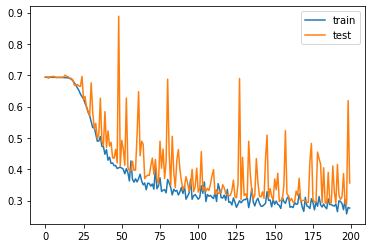

In [60]:
history1 = VanillaLSTM.fit(X_train, y_train, epochs=200, verbose=1, validation_data=(X_val,y_val), batch_size=batch_size)
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 4016 samples, validate on 1004 samples
Epoch 1/200
4016/4016 [==============================] - 2s 381us/step - loss: 0.6942 - accuracy: 0.4885 - val_loss: 0.6926 - val_accuracy: 0.5598
Epoch 2/200
4016/4016 [==============================] - 1s 160us/step - loss: 0.6938 - accuracy: 0.5005 - val_loss: 0.6924 - val_accuracy: 0.5598
Epoch 3/200
4016/4016 [==============================] - 1s 160us/step - loss: 0.6934 - accuracy: 0.5072 - val_loss: 0.6940 - val_accuracy: 0.4402
Epoch 4/200
4016/4016 [==============================] - 1s 162us/step - loss: 0.6928 - accuracy: 0.5077 - val_loss: 0.7038 - val_accuracy: 0.4402
Epoch 5/200
4016/4016 [==============================] - 1s 172us/step - loss: 0.6940 - accuracy: 0.5017 - val_loss: 0.6938 - val_accuracy: 0.4402
Epoch 6/200
4016/4016 [==============================] - 1s 164us/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6927 - val_accuracy: 0.5747
Epoch 7/200
4016/4016 [==============================] - 1s 165us/step

4016/4016 [==============================] - 1s 157us/step - loss: 0.3905 - accuracy: 0.8394 - val_loss: 0.5169 - val_accuracy: 0.6733
Epoch 57/200
4016/4016 [==============================] - 1s 155us/step - loss: 0.3885 - accuracy: 0.8302 - val_loss: 0.4179 - val_accuracy: 0.8904
Epoch 58/200
4016/4016 [==============================] - 1s 158us/step - loss: 0.3872 - accuracy: 0.8441 - val_loss: 0.5498 - val_accuracy: 0.6564
Epoch 59/200
4016/4016 [==============================] - 1s 160us/step - loss: 0.3905 - accuracy: 0.8364 - val_loss: 0.4175 - val_accuracy: 0.8058
Epoch 60/200
4016/4016 [==============================] - 1s 157us/step - loss: 0.3745 - accuracy: 0.8543 - val_loss: 0.4927 - val_accuracy: 0.6833
Epoch 61/200
4016/4016 [==============================] - 1s 156us/step - loss: 0.3838 - accuracy: 0.8451 - val_loss: 0.5832 - val_accuracy: 0.6116
Epoch 62/200
4016/4016 [==============================] - 1s 158us/step - loss: 0.3772 - accuracy: 0.8454 - val_loss: 0.3950 

4016/4016 [==============================] - 1s 163us/step - loss: 0.2894 - accuracy: 0.8870 - val_loss: 0.3740 - val_accuracy: 0.7988
Epoch 112/200
4016/4016 [==============================] - 1s 168us/step - loss: 0.2777 - accuracy: 0.9011 - val_loss: 0.3335 - val_accuracy: 0.8536
Epoch 113/200
4016/4016 [==============================] - 1s 166us/step - loss: 0.2786 - accuracy: 0.8962 - val_loss: 0.3244 - val_accuracy: 0.9044
Epoch 114/200
4016/4016 [==============================] - 1s 177us/step - loss: 0.2862 - accuracy: 0.8894 - val_loss: 0.3475 - val_accuracy: 0.8287
Epoch 115/200
4016/4016 [==============================] - 1s 178us/step - loss: 0.2588 - accuracy: 0.9250 - val_loss: 0.2980 - val_accuracy: 0.9651
Epoch 116/200
4016/4016 [==============================] - 1s 164us/step - loss: 0.2614 - accuracy: 0.9146 - val_loss: 0.3017 - val_accuracy: 0.9572
Epoch 117/200
4016/4016 [==============================] - 1s 154us/step - loss: 0.2644 - accuracy: 0.9094 - val_loss: 0

4016/4016 [==============================] - 1s 161us/step - loss: 0.2446 - accuracy: 0.9146 - val_loss: 0.2974 - val_accuracy: 0.8924
Epoch 167/200
4016/4016 [==============================] - 1s 159us/step - loss: 0.2340 - accuracy: 0.9191 - val_loss: 0.2630 - val_accuracy: 0.9711
Epoch 168/200
4016/4016 [==============================] - 1s 155us/step - loss: 0.2500 - accuracy: 0.9026 - val_loss: 0.3013 - val_accuracy: 0.8685
Epoch 169/200
4016/4016 [==============================] - 1s 155us/step - loss: 0.2275 - accuracy: 0.9268 - val_loss: 0.2611 - val_accuracy: 0.9532
Epoch 170/200
4016/4016 [==============================] - 1s 192us/step - loss: 0.2304 - accuracy: 0.9223 - val_loss: 0.2623 - val_accuracy: 0.9602
Epoch 171/200
4016/4016 [==============================] - 1s 167us/step - loss: 0.2546 - accuracy: 0.9014 - val_loss: 0.3977 - val_accuracy: 0.7779
Epoch 172/200
4016/4016 [==============================] - 1s 156us/step - loss: 0.2574 - accuracy: 0.8974 - val_loss: 0

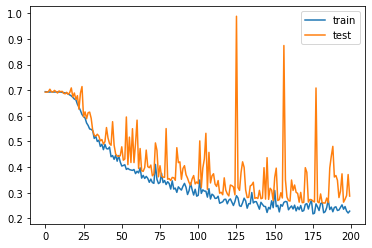

In [61]:
history2 = BidirectionalLSTM.fit(X_train, y_train, epochs=200, verbose=1, validation_data=(X_val,y_val), batch_size=batch_size)
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 4016 samples, validate on 1004 samples
Epoch 1/300
4016/4016 [==============================] - 0s 110us/step - loss: 0.6934 - accuracy: 0.5107 - val_loss: 0.7017 - val_accuracy: 0.4402
Epoch 2/300
4016/4016 [==============================] - 0s 49us/step - loss: 0.6902 - accuracy: 0.5279 - val_loss: 0.6846 - val_accuracy: 0.5807
Epoch 3/300
4016/4016 [==============================] - 0s 50us/step - loss: 0.6785 - accuracy: 0.5976 - val_loss: 0.6761 - val_accuracy: 0.5219
Epoch 4/300
4016/4016 [==============================] - 0s 54us/step - loss: 0.6391 - accuracy: 0.6723 - val_loss: 0.6064 - val_accuracy: 0.7112
Epoch 5/300
4016/4016 [==============================] - 0s 50us/step - loss: 0.5659 - accuracy: 0.7388 - val_loss: 0.5252 - val_accuracy: 0.8596
Epoch 6/300
4016/4016 [==============================] - 0s 50us/step - loss: 0.5009 - accuracy: 0.7600 - val_loss: 0.5224 - val_accuracy: 0.7052
Epoch 7/300
4016/4016 [==============================] - 0s 57us/step - los

4016/4016 [==============================] - 0s 50us/step - loss: 0.1607 - accuracy: 0.9415 - val_loss: 0.2766 - val_accuracy: 0.8815
Epoch 57/300
4016/4016 [==============================] - 0s 49us/step - loss: 0.1916 - accuracy: 0.9228 - val_loss: 0.2335 - val_accuracy: 0.9153
Epoch 58/300
4016/4016 [==============================] - 0s 49us/step - loss: 0.1625 - accuracy: 0.9397 - val_loss: 0.1921 - val_accuracy: 0.9631
Epoch 59/300
4016/4016 [==============================] - 0s 53us/step - loss: 0.1603 - accuracy: 0.9427 - val_loss: 0.4282 - val_accuracy: 0.8197
Epoch 60/300
4016/4016 [==============================] - 0s 56us/step - loss: 0.1630 - accuracy: 0.9340 - val_loss: 0.3314 - val_accuracy: 0.8516
Epoch 61/300
4016/4016 [==============================] - 0s 50us/step - loss: 0.1475 - accuracy: 0.9502 - val_loss: 0.2093 - val_accuracy: 0.9283
Epoch 62/300
4016/4016 [==============================] - 0s 49us/step - loss: 0.1633 - accuracy: 0.9382 - val_loss: 0.2062 - val_a

Epoch 112/300
4016/4016 [==============================] - 0s 60us/step - loss: 0.1425 - accuracy: 0.9497 - val_loss: 0.2880 - val_accuracy: 0.8765
Epoch 113/300
4016/4016 [==============================] - 0s 52us/step - loss: 0.1290 - accuracy: 0.9547 - val_loss: 0.2291 - val_accuracy: 0.9133
Epoch 114/300
4016/4016 [==============================] - 0s 55us/step - loss: 0.1612 - accuracy: 0.9358 - val_loss: 0.4801 - val_accuracy: 0.8167
Epoch 115/300
4016/4016 [==============================] - 0s 55us/step - loss: 0.1998 - accuracy: 0.9168 - val_loss: 0.1938 - val_accuracy: 0.9622
Epoch 116/300
4016/4016 [==============================] - 0s 51us/step - loss: 0.1538 - accuracy: 0.9375 - val_loss: 0.2629 - val_accuracy: 0.8825
Epoch 117/300
4016/4016 [==============================] - 0s 50us/step - loss: 0.1683 - accuracy: 0.9300 - val_loss: 0.1953 - val_accuracy: 0.9522
Epoch 118/300
4016/4016 [==============================] - 0s 55us/step - loss: 0.1301 - accuracy: 0.9564 - val_

4016/4016 [==============================] - 0s 52us/step - loss: 0.1225 - accuracy: 0.9539 - val_loss: 0.1707 - val_accuracy: 0.9532
Epoch 168/300
4016/4016 [==============================] - 0s 51us/step - loss: 0.1317 - accuracy: 0.9492 - val_loss: 0.2120 - val_accuracy: 0.9233
Epoch 169/300
4016/4016 [==============================] - 0s 49us/step - loss: 0.1196 - accuracy: 0.9534 - val_loss: 0.1645 - val_accuracy: 0.9681
Epoch 170/300
4016/4016 [==============================] - 0s 49us/step - loss: 0.1176 - accuracy: 0.9584 - val_loss: 0.1965 - val_accuracy: 0.9343
Epoch 171/300
4016/4016 [==============================] - 0s 49us/step - loss: 0.1156 - accuracy: 0.9567 - val_loss: 0.1655 - val_accuracy: 0.9701
Epoch 172/300
4016/4016 [==============================] - 0s 51us/step - loss: 0.1678 - accuracy: 0.9320 - val_loss: 0.1817 - val_accuracy: 0.9522
Epoch 173/300
4016/4016 [==============================] - 0s 52us/step - loss: 0.1122 - accuracy: 0.9624 - val_loss: 0.1781 -

4016/4016 [==============================] - 0s 55us/step - loss: 0.1073 - accuracy: 0.9622 - val_loss: 0.1632 - val_accuracy: 0.9552
Epoch 223/300
4016/4016 [==============================] - 0s 48us/step - loss: 0.1073 - accuracy: 0.9599 - val_loss: 0.1667 - val_accuracy: 0.9701
Epoch 224/300
4016/4016 [==============================] - 0s 53us/step - loss: 0.1015 - accuracy: 0.9634 - val_loss: 0.1862 - val_accuracy: 0.9412
Epoch 225/300
4016/4016 [==============================] - 0s 75us/step - loss: 0.1277 - accuracy: 0.9482 - val_loss: 0.2490 - val_accuracy: 0.8984
Epoch 226/300
4016/4016 [==============================] - 0s 49us/step - loss: 0.1215 - accuracy: 0.9534 - val_loss: 0.1584 - val_accuracy: 0.9691
Epoch 227/300
4016/4016 [==============================] - 0s 67us/step - loss: 0.0954 - accuracy: 0.9676 - val_loss: 0.1918 - val_accuracy: 0.9323
Epoch 228/300
4016/4016 [==============================] - 0s 54us/step - loss: 0.1077 - accuracy: 0.9609 - val_loss: 0.1697 -

4016/4016 [==============================] - 0s 47us/step - loss: 0.1002 - accuracy: 0.9624 - val_loss: 0.1652 - val_accuracy: 0.9562
Epoch 278/300
4016/4016 [==============================] - 0s 50us/step - loss: 0.0881 - accuracy: 0.9711 - val_loss: 0.1607 - val_accuracy: 0.9701
Epoch 279/300
4016/4016 [==============================] - 0s 53us/step - loss: 0.0924 - accuracy: 0.9689 - val_loss: 0.1886 - val_accuracy: 0.9353
Epoch 280/300
4016/4016 [==============================] - 0s 50us/step - loss: 0.1112 - accuracy: 0.9554 - val_loss: 0.1921 - val_accuracy: 0.9353
Epoch 281/300
4016/4016 [==============================] - 0s 49us/step - loss: 0.0858 - accuracy: 0.9714 - val_loss: 0.1727 - val_accuracy: 0.9731
Epoch 282/300
4016/4016 [==============================] - 0s 60us/step - loss: 0.0888 - accuracy: 0.9714 - val_loss: 0.1864 - val_accuracy: 0.9572
Epoch 283/300
4016/4016 [==============================] - 0s 56us/step - loss: 0.1042 - accuracy: 0.9599 - val_loss: 0.2971 -

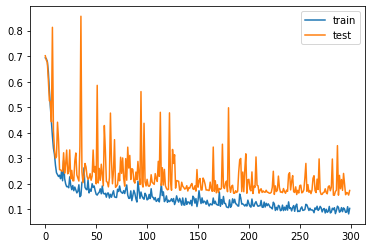

In [62]:
history3 = CNN.fit(X_train, y_train, epochs=300, verbose=1, validation_data=(X_val,y_val), batch_size=batch_size)
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 4016 samples, validate on 1004 samples
Epoch 1/400
4016/4016 [==============================] - 0s 96us/step - loss: 0.6528 - accuracy: 0.6168 - val_loss: 0.6536 - val_accuracy: 0.6305
Epoch 2/400
4016/4016 [==============================] - 0s 90us/step - loss: 0.6522 - accuracy: 0.6168 - val_loss: 0.6538 - val_accuracy: 0.6265
Epoch 3/400
4016/4016 [==============================] - 0s 90us/step - loss: 0.6519 - accuracy: 0.6160 - val_loss: 0.6521 - val_accuracy: 0.6414
Epoch 4/400
4016/4016 [==============================] - 0s 92us/step - loss: 0.6520 - accuracy: 0.6188 - val_loss: 0.6538 - val_accuracy: 0.6335
Epoch 5/400
4016/4016 [==============================] - 0s 90us/step - loss: 0.6515 - accuracy: 0.6170 - val_loss: 0.6513 - val_accuracy: 0.6384
Epoch 6/400
4016/4016 [==============================] - 0s 91us/step - loss: 0.6523 - accuracy: 0.6150 - val_loss: 0.6543 - val_accuracy: 0.6285
Epoch 7/400
4016/4016 [==============================] - 0s 90us/step - loss

4016/4016 [==============================] - 0s 81us/step - loss: 0.6501 - accuracy: 0.6200 - val_loss: 0.6472 - val_accuracy: 0.6355
Epoch 57/400
4016/4016 [==============================] - 0s 91us/step - loss: 0.6505 - accuracy: 0.6153 - val_loss: 0.6610 - val_accuracy: 0.6006
Epoch 58/400
4016/4016 [==============================] - 0s 92us/step - loss: 0.6492 - accuracy: 0.6153 - val_loss: 0.6512 - val_accuracy: 0.6424
Epoch 59/400
4016/4016 [==============================] - 0s 96us/step - loss: 0.6489 - accuracy: 0.6243 - val_loss: 0.6496 - val_accuracy: 0.6335
Epoch 60/400
4016/4016 [==============================] - 0s 99us/step - loss: 0.6498 - accuracy: 0.6140 - val_loss: 0.6578 - val_accuracy: 0.6155
Epoch 61/400
4016/4016 [==============================] - 0s 90us/step - loss: 0.6503 - accuracy: 0.6135 - val_loss: 0.6605 - val_accuracy: 0.6006
Epoch 62/400
4016/4016 [==============================] - 0s 92us/step - loss: 0.6499 - accuracy: 0.6173 - val_loss: 0.6733 - val_a

Epoch 112/400
4016/4016 [==============================] - 0s 108us/step - loss: 0.6490 - accuracy: 0.6160 - val_loss: 0.6744 - val_accuracy: 0.5478
Epoch 113/400
4016/4016 [==============================] - 0s 101us/step - loss: 0.6473 - accuracy: 0.6163 - val_loss: 0.6452 - val_accuracy: 0.6345
Epoch 114/400
4016/4016 [==============================] - 0s 92us/step - loss: 0.6462 - accuracy: 0.6218 - val_loss: 0.6507 - val_accuracy: 0.6335
Epoch 115/400
4016/4016 [==============================] - 0s 92us/step - loss: 0.6490 - accuracy: 0.6165 - val_loss: 0.6596 - val_accuracy: 0.6135
Epoch 116/400
4016/4016 [==============================] - 0s 96us/step - loss: 0.6451 - accuracy: 0.6205 - val_loss: 0.6443 - val_accuracy: 0.6355
Epoch 117/400
4016/4016 [==============================] - 0s 93us/step - loss: 0.6494 - accuracy: 0.6133 - val_loss: 0.6504 - val_accuracy: 0.6384
Epoch 118/400
4016/4016 [==============================] - 0s 93us/step - loss: 0.6472 - accuracy: 0.6190 - va

4016/4016 [==============================] - 0s 88us/step - loss: 0.6451 - accuracy: 0.6213 - val_loss: 0.6436 - val_accuracy: 0.6434
Epoch 168/400
4016/4016 [==============================] - 0s 99us/step - loss: 0.6465 - accuracy: 0.6148 - val_loss: 0.6487 - val_accuracy: 0.6414
Epoch 169/400
4016/4016 [==============================] - 0s 83us/step - loss: 0.6467 - accuracy: 0.6228 - val_loss: 0.6501 - val_accuracy: 0.6414
Epoch 170/400
4016/4016 [==============================] - 0s 95us/step - loss: 0.6463 - accuracy: 0.6235 - val_loss: 0.6481 - val_accuracy: 0.6384
Epoch 171/400
4016/4016 [==============================] - 0s 93us/step - loss: 0.6463 - accuracy: 0.6220 - val_loss: 0.6514 - val_accuracy: 0.6335
Epoch 172/400
4016/4016 [==============================] - 0s 99us/step - loss: 0.6464 - accuracy: 0.6223 - val_loss: 0.6504 - val_accuracy: 0.6375
Epoch 173/400
4016/4016 [==============================] - 0s 92us/step - loss: 0.6466 - accuracy: 0.6240 - val_loss: 0.6468 -

4016/4016 [==============================] - 0s 91us/step - loss: 0.6452 - accuracy: 0.6230 - val_loss: 0.6402 - val_accuracy: 0.6315
Epoch 223/400
4016/4016 [==============================] - 0s 83us/step - loss: 0.6448 - accuracy: 0.6183 - val_loss: 0.6447 - val_accuracy: 0.6404
Epoch 224/400
4016/4016 [==============================] - 0s 83us/step - loss: 0.6426 - accuracy: 0.6240 - val_loss: 0.6424 - val_accuracy: 0.6335
Epoch 225/400
4016/4016 [==============================] - 0s 96us/step - loss: 0.6443 - accuracy: 0.6238 - val_loss: 0.6511 - val_accuracy: 0.6325
Epoch 226/400
4016/4016 [==============================] - 0s 87us/step - loss: 0.6438 - accuracy: 0.6183 - val_loss: 0.6443 - val_accuracy: 0.6355
Epoch 227/400
4016/4016 [==============================] - 0s 93us/step - loss: 0.6438 - accuracy: 0.6235 - val_loss: 0.6585 - val_accuracy: 0.6016
Epoch 228/400
4016/4016 [==============================] - 0s 94us/step - loss: 0.6438 - accuracy: 0.6302 - val_loss: 0.6426 -

4016/4016 [==============================] - 0s 86us/step - loss: 0.6432 - accuracy: 0.6203 - val_loss: 0.6400 - val_accuracy: 0.6345
Epoch 278/400
4016/4016 [==============================] - 0s 94us/step - loss: 0.6435 - accuracy: 0.6285 - val_loss: 0.6531 - val_accuracy: 0.6255
Epoch 279/400
4016/4016 [==============================] - 0s 84us/step - loss: 0.6443 - accuracy: 0.6170 - val_loss: 0.6478 - val_accuracy: 0.6414
Epoch 280/400
4016/4016 [==============================] - 0s 91us/step - loss: 0.6433 - accuracy: 0.6215 - val_loss: 0.6470 - val_accuracy: 0.6434
Epoch 281/400
4016/4016 [==============================] - 0s 102us/step - loss: 0.6440 - accuracy: 0.6180 - val_loss: 0.6548 - val_accuracy: 0.6235
Epoch 282/400
4016/4016 [==============================] - 0s 84us/step - loss: 0.6431 - accuracy: 0.6195 - val_loss: 0.6495 - val_accuracy: 0.6414
Epoch 283/400
4016/4016 [==============================] - 0s 85us/step - loss: 0.6437 - accuracy: 0.6235 - val_loss: 0.6480 

4016/4016 [==============================] - 0s 95us/step - loss: 0.6438 - accuracy: 0.6235 - val_loss: 0.6416 - val_accuracy: 0.6295
Epoch 333/400
4016/4016 [==============================] - 0s 89us/step - loss: 0.6449 - accuracy: 0.6175 - val_loss: 0.6446 - val_accuracy: 0.6444
Epoch 334/400
4016/4016 [==============================] - 0s 83us/step - loss: 0.6419 - accuracy: 0.6282 - val_loss: 0.6383 - val_accuracy: 0.6345
Epoch 335/400
4016/4016 [==============================] - 0s 93us/step - loss: 0.6441 - accuracy: 0.6255 - val_loss: 0.6456 - val_accuracy: 0.6474
Epoch 336/400
4016/4016 [==============================] - 0s 92us/step - loss: 0.6435 - accuracy: 0.6208 - val_loss: 0.6544 - val_accuracy: 0.6205
Epoch 337/400
4016/4016 [==============================] - 0s 81us/step - loss: 0.6442 - accuracy: 0.6208 - val_loss: 0.6521 - val_accuracy: 0.6305
Epoch 338/400
4016/4016 [==============================] - 0s 85us/step - loss: 0.6435 - accuracy: 0.6265 - val_loss: 0.6549 -

4016/4016 [==============================] - 0s 93us/step - loss: 0.6422 - accuracy: 0.6238 - val_loss: 0.6452 - val_accuracy: 0.6384
Epoch 388/400
4016/4016 [==============================] - 0s 94us/step - loss: 0.6426 - accuracy: 0.6235 - val_loss: 0.6416 - val_accuracy: 0.6355
Epoch 389/400
4016/4016 [==============================] - 0s 91us/step - loss: 0.6425 - accuracy: 0.6262 - val_loss: 0.6485 - val_accuracy: 0.6494
Epoch 390/400
4016/4016 [==============================] - 0s 91us/step - loss: 0.6417 - accuracy: 0.6270 - val_loss: 0.6522 - val_accuracy: 0.6275
Epoch 391/400
4016/4016 [==============================] - 0s 90us/step - loss: 0.6422 - accuracy: 0.6205 - val_loss: 0.6462 - val_accuracy: 0.6414
Epoch 392/400
4016/4016 [==============================] - 0s 90us/step - loss: 0.6445 - accuracy: 0.6205 - val_loss: 0.6602 - val_accuracy: 0.5956
Epoch 393/400
4016/4016 [==============================] - 0s 90us/step - loss: 0.6471 - accuracy: 0.6145 - val_loss: 0.6484 -

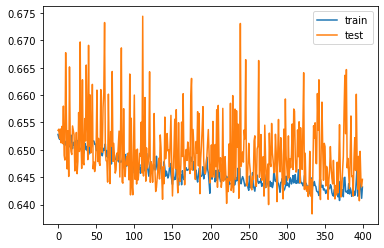

In [65]:
history4 = CNNLSTM.fit(X_train.reshape((X_train.shape[0], 2, 2, n_indicators)), 
                       y_train, epochs=400, verbose=1, batch_size=batch_size,
                       validation_data=(X_val.reshape((X_val.shape[0], 2, 2, n_indicators)),y_val))
plt.plot(history4.history['loss'], label='train')
plt.plot(history4.history['val_loss'], label='test')
plt.legend()
plt.show()

Train on 4016 samples, validate on 1004 samples
Epoch 1/200
4016/4016 [==============================] - 2s 396us/step - loss: 0.6943 - accuracy: 0.4846 - val_loss: 0.6924 - val_accuracy: 0.5598
Epoch 2/200
4016/4016 [==============================] - 1s 159us/step - loss: 0.6937 - accuracy: 0.4905 - val_loss: 0.6957 - val_accuracy: 0.4402
Epoch 3/200
4016/4016 [==============================] - 1s 158us/step - loss: 0.6936 - accuracy: 0.4965 - val_loss: 0.6914 - val_accuracy: 0.5598
Epoch 4/200
4016/4016 [==============================] - 1s 160us/step - loss: 0.6926 - accuracy: 0.5281 - val_loss: 0.7040 - val_accuracy: 0.4402
Epoch 5/200
4016/4016 [==============================] - 1s 160us/step - loss: 0.6934 - accuracy: 0.5047 - val_loss: 0.6920 - val_accuracy: 0.5598
Epoch 6/200
4016/4016 [==============================] - 1s 157us/step - loss: 0.6929 - accuracy: 0.5035 - val_loss: 0.6963 - val_accuracy: 0.4402
Epoch 7/200
4016/4016 [==============================] - 1s 158us/step

4016/4016 [==============================] - 1s 167us/step - loss: 0.4933 - accuracy: 0.7714 - val_loss: 0.5246 - val_accuracy: 0.7799
Epoch 57/200
4016/4016 [==============================] - 1s 183us/step - loss: 0.4813 - accuracy: 0.8000 - val_loss: 0.5139 - val_accuracy: 0.8098
Epoch 58/200
4016/4016 [==============================] - 1s 173us/step - loss: 0.4864 - accuracy: 0.7781 - val_loss: 0.5739 - val_accuracy: 0.6663
Epoch 59/200
4016/4016 [==============================] - 1s 224us/step - loss: 0.4753 - accuracy: 0.7981 - val_loss: 0.5072 - val_accuracy: 0.8127
Epoch 60/200
4016/4016 [==============================] - 1s 216us/step - loss: 0.4667 - accuracy: 0.8048 - val_loss: 0.5015 - val_accuracy: 0.8177
Epoch 61/200
4016/4016 [==============================] - 1s 209us/step - loss: 0.4698 - accuracy: 0.7911 - val_loss: 0.5113 - val_accuracy: 0.7659
Epoch 62/200
4016/4016 [==============================] - 1s 201us/step - loss: 0.4780 - accuracy: 0.7771 - val_loss: 0.5018 

4016/4016 [==============================] - 1s 157us/step - loss: 0.3373 - accuracy: 0.8576 - val_loss: 0.4537 - val_accuracy: 0.7600
Epoch 112/200
4016/4016 [==============================] - 1s 154us/step - loss: 0.3389 - accuracy: 0.8586 - val_loss: 0.4192 - val_accuracy: 0.8018
Epoch 113/200
4016/4016 [==============================] - 1s 150us/step - loss: 0.3392 - accuracy: 0.8566 - val_loss: 0.3869 - val_accuracy: 0.8486
Epoch 114/200
4016/4016 [==============================] - 1s 147us/step - loss: 0.3332 - accuracy: 0.8606 - val_loss: 0.3738 - val_accuracy: 0.8695
Epoch 115/200
4016/4016 [==============================] - 1s 148us/step - loss: 0.3321 - accuracy: 0.8608 - val_loss: 0.3806 - val_accuracy: 0.8536
Epoch 116/200
4016/4016 [==============================] - 1s 152us/step - loss: 0.3225 - accuracy: 0.8708 - val_loss: 0.3806 - val_accuracy: 0.8496
Epoch 117/200
4016/4016 [==============================] - 1s 151us/step - loss: 0.3343 - accuracy: 0.8583 - val_loss: 0

4016/4016 [==============================] - 1s 160us/step - loss: 0.2605 - accuracy: 0.8977 - val_loss: 0.3104 - val_accuracy: 0.9004
Epoch 167/200
4016/4016 [==============================] - 1s 161us/step - loss: 0.2936 - accuracy: 0.8770 - val_loss: 0.3067 - val_accuracy: 0.9104
Epoch 168/200
4016/4016 [==============================] - 1s 168us/step - loss: 0.2682 - accuracy: 0.8912 - val_loss: 0.3257 - val_accuracy: 0.8705
Epoch 169/200
4016/4016 [==============================] - 1s 153us/step - loss: 0.2671 - accuracy: 0.8967 - val_loss: 0.3366 - val_accuracy: 0.8635
Epoch 170/200
4016/4016 [==============================] - 1s 148us/step - loss: 0.2609 - accuracy: 0.8927 - val_loss: 0.3075 - val_accuracy: 0.9044
Epoch 171/200
4016/4016 [==============================] - 1s 146us/step - loss: 0.2571 - accuracy: 0.9014 - val_loss: 0.3029 - val_accuracy: 0.9183
Epoch 172/200
4016/4016 [==============================] - 1s 150us/step - loss: 0.2540 - accuracy: 0.8979 - val_loss: 0

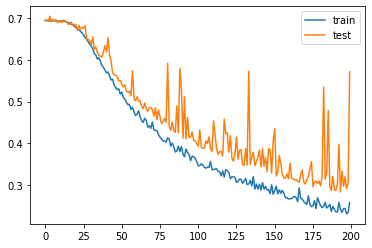

In [68]:
history5 = ConvLSTM.fit(X_train.reshape((X_train.shape[0], 2, 1, 2, n_indicators)), 
                       y_train, epochs=200, verbose=1, batch_size=batch_size,
                       validation_data=(X_val.reshape((X_val.shape[0], 2, 1, 2, n_indicators)),y_val))
plt.plot(history5.history['loss'], label='train')
plt.plot(history5.history['val_loss'], label='test')
plt.legend()
plt.show()